In [226]:
#importing modules
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library
#importing modules
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import requests
!conda install -c conda-forge folium=0.5.0
import folium

Solving environment: done

# All requested packages already installed.



In [227]:
# importing data sets for both cites
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

# Looking for an optimal place for relocation

## Introduction

Relocation to another country or state is a relatively common situation. For many people the reason for relocation is a new job (often some advancement in their career) or studies. In any case, it can be a wonderful experience for the person traveling alone or for the whole family to experience living in another place and to get familiar with a different culture.
I personally plan a relocation to Waltham, Massachusetts for one year, to work in a research laboratory. I hope that the code presented here may help other people to find an optimal place for relocation.

In order to find an appropriate place to live with the family and to work in Waltham, we have set several priorities:

1. Distance from workplace
2. Safety
3. A quiet environment with basic supply stores and restaurants

In order to satisfy these requirements, I have investigated geospatial data of Massachusetts municipalities (unique postal code zones), an FBI data on crimes in Massachusetts and Foursquare data information on venues in each zone.

## Data

A database of Massachusetts municipalities by postal codes was publicly available on url:
https://public.opendatasoft.com/explore/dataset/us-zip-code-latitude-and-longitude/export/?refine.state=MA
The data was available for download as a csv file, including postal code zone numbers, municipality names and latitude and longitude of each zone.

Using geospatial location of the laboratory, I was able to calculate the distance from the laboratory to each postal code zone and to sort out all zones that were more than 15 km far from it.

Safety data was obtained from an open FBI dataset of number of crimes by town in Massachusetts in 2013. 
Url is https://ucr.fbi.gov/crime-in-the-u.s/2013/crime-in-the-u.s.-2013/tables/table-8/table-8-state-cuts/table_8_offenses_known_to_law_enforcement_massachusetts_by_city_2013.xls
File name is 'table_8_offenses_known_to_law_enforcement_massachusetts_by_city_2013.xls'
The file contains each town's population and number of violent crime and property crime cases during 2013. Based on these numbers we will be able to calculate rates of both types of crime in each city.

Foursquare account was opened in order to query venue data in each postal code zones. The venues were then sorted and 10 most frequent venue types were presented.

The postal code zones were then clustered based on the Foursquare and criminal data. Optimal number of clusters was applied using an "elbow" plot of error for each number of clusters.

Next, the rates of property and violent crime were summarized and visualized for each cluster using barplots.

Clusters with lowest number of crimes were inspected for most frequent venues. Based on this data, an optimal place for relocation was selected.

## Methodology

### Finding locations for all postal code zones in Massachusetts

We will begin by loading an open database of Massacusetts municipalities and plotting them on a map. The map will be centered over Waltham.

In [269]:
df2 = pd.read_csv("/home/stanok/Documents/Machine learning/Capstone Final Assignment/boston_zip.csv")
df2.head()

,Zip,City,State,Latitude,Longitude,Timezone,Daylight savings time flag
0,2472,Watertown,MA,42.371296,-71.18196,-5,1
1,2169,Quincy,MA,42.250739,-70.99593,-5,1
2,2375,South Easton,MA,42.029749,-71.10191,-5,1
3,2639,Dennis Port,MA,41.661115,-70.13348,-5,1
4,2382,Whitman,MA,42.082350,-70.93734,-5,1


The total number of municipalities is 766

In [270]:
df2.shape

(766, 7)

We will find coordinates of the Laboratory and center the map around them

In [271]:
address = '52 Second Avenue, Waltham, MA,  02451'

geolocator = Nominatim(user_agent="schermann")
location = geolocator.geocode(address)
latW = location.latitude
lonW = location.longitude
print('The geograpical coordinate of Waltham, MA are {}, {}.'.format(latW, lonW))

The geograpical coordinate of Waltham, MA are 42.3954115, -71.2635229.


The following code will create a map of Massachusetts and add marker for each municipality

In [272]:
map_mass = folium.Map(location=[latW, lonW], zoom_start=8)

# add markers to map
for lat, lng, label in zip(df2['Latitude'], df2['Longitude'], df2 ['City']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_mass)  
    
map_mass

### Selection of municipalities within 15 km from workplace

First, we will calculate the distance from the laboratory to each postal code zone

In [273]:
from math import sin, cos, sqrt, atan2, radians
R = 6373.0  # approximate radius of earth in km
Distance=[]
lat1=latW
lon1=lonW

for index,d in df2.iterrows():
    lat1 = radians(latW)
    lon1 = radians(lonW)
    lat2 = radians(d['Latitude'])
    lon2 = radians(d['Longitude'])
    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))

    distance = R * c
    Distance.append(distance)

In [274]:
Dis=pd.DataFrame(Distance)
Dis.columns=['Distance']
dfm=df2.join(Dis)

dfm.head()

,Zip,City,State,Latitude,Longitude,Timezone,Daylight savings time flag,Distance
0,2472,Watertown,MA,42.371296,-71.18196,-5,1,7.218124
1,2169,Quincy,MA,42.250739,-70.99593,-5,1,27.262351
2,2375,South Easton,MA,42.029749,-71.10191,-5,1,42.796308
3,2639,Dennis Port,MA,41.661115,-70.13348,-5,1,124.048006
4,2382,Whitman,MA,42.082350,-70.93734,-5,1,43.977847


Next, we will focus on Massachusetts postal code zones within 20 km from the lab. Zones satisfying this condition will be mapped using green markers, whereas zones out of the ranged will be marked with red

In [275]:
Range=[]
Color=[]

for row in dfm['Distance']:
    # if more than a value,
    if row > 15:
        Range.append('No')
        Color.append('red')
    # else, if less than a value,
    else:
        Range.append('Yes')
        Color.append('green')

In [276]:
dfm['Range'] = Range
dfm['Color'] = Color

In [277]:
dfm.loc[dfm['City'] == 'Boston', ['Color']] = 'red'
dfm.loc[dfm['City'] == 'Boston', ['Range']] = 'No'

In [278]:
dfm.shape

(766, 10)

In [279]:
dfm.head(5)

,Zip,City,State,Latitude,Longitude,Timezone,Daylight savings time flag,Distance,Range,Color
0,2472,Watertown,MA,42.371296,-71.18196,-5,1,7.218124,Yes,green
1,2169,Quincy,MA,42.250739,-70.99593,-5,1,27.262351,No,red
2,2375,South Easton,MA,42.029749,-71.10191,-5,1,42.796308,No,red
3,2639,Dennis Port,MA,41.661115,-70.13348,-5,1,124.048006,No,red
4,2382,Whitman,MA,42.082350,-70.93734,-5,1,43.977847,No,red


In [280]:
locations = dfm[['Latitude', 'Longitude']]
locationlist = locations.values.tolist()

In [281]:
map_mass = folium.Map(location=[latW, lonW], zoom_start=11)

for point in range(0, len(locationlist)):
    folium.Marker(locationlist[point],
                  icon=folium.Icon(color=dfm["Color"][point],
                                   icon_color='white',
                                   icon='circle',
                                   angle=0, prefix='fa')).add_to(map_mass)

display(map_mass)

Now we can proceed to collecting information about the selected zones. Our working database will be limited to municipalities within the range of 20 km from workplace.

In [282]:
dfm=dfm[dfm.Range=='Yes']

In [283]:
dfm.head()

,Zip,City,State,Latitude,Longitude,Timezone,Daylight savings time flag,Distance,Range,Color
0,2472,Watertown,MA,42.371296,-71.181960,-5,1,7.218124,Yes,green
11,2139,Cambridge,MA,42.364347,-71.104310,-5,1,13.530298,Yes,green
45,2154,Waltham,MA,42.388938,-71.239800,-5,1,2.077569,Yes,green
48,2159,Newton,MA,42.316097,-71.191248,-5,1,10.635895,Yes,green
65,2174,Arlington,MA,42.417695,-71.167083,-5,1,8.299335,Yes,green


In [284]:
dfm.shape

(57, 10)

Number of selected zones was reduced to 57.
In the following steps, we will explore municipalities data and find information regarding local crime rates and education.

### Local venues information

The following code will extract venues for each postal code zone and will summarize them by vanue categories. The output will be 10 most common venues in each zone. Then, using one hot encoding we will prepare this database for clustering. Crime rates data will be joined with venue data prior to clustering

In [285]:
CLIENT_ID = 'CXVHOXS3XFVOH4LE4JDA11E1UVV5K2XERJI1HGJC0E2OPI34' # Foursquare ID
CLIENT_SECRET = 'ZBPDHSCMS5X40120CMYJ2CLTAKXYQAUCDIAD5TPPRWYW4MPX' # Foursquare Secret
VERSION = '20180605'
LIMIT = 300
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: CXVHOXS3XFVOH4LE4JDA11E1UVV5K2XERJI1HGJC0E2OPI34
CLIENT_SECRET:ZBPDHSCMS5X40120CMYJ2CLTAKXYQAUCDIAD5TPPRWYW4MPX


In [286]:
def getNearbyVenues(names, latitudes, longitudes, radius=500, LIMIT=100):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Street', 
                  'Street Latitude', 
                  'Street Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [287]:
mass_venues = getNearbyVenues(names=dfm['Zip'],
                                   latitudes=dfm['Latitude'],
                                   longitudes=dfm['Longitude'])


In [288]:
mass_venues.shape

(1046, 7)

In [289]:
mass_venues.head()

,Street,Street Latitude,Street Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,2472,42.371296,-71.18196,Victory Field,42.373526,-71.181643,Playground
1,2472,42.371296,-71.18196,Roksana's Persian Food,42.367706,-71.178894,Persian Restaurant
2,2472,42.371296,-71.18196,FruttiBerri,42.367706,-71.178894,Frozen Yogurt Shop
3,2472,42.371296,-71.18196,Kareem Restaurant,42.371509,-71.178628,Middle Eastern Restaurant
4,2472,42.371296,-71.18196,Step By Step Cleaning Services,42.369388,-71.177212,Home Service


One hot encoding

In [290]:
# one hot encoding
mass_onehot = pd.get_dummies(mass_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
mass_onehot['Zip'] = mass_venues['Street'] 

# move neighborhood column to the first column
fixed_columns = [mass_onehot.columns[-1]] + list(mass_onehot.columns[:-1])
mass_onehot = mass_onehot[fixed_columns]
mass_grouped = mass_onehot.groupby('Zip').mean().reset_index()
mass_onehot.shape

(1046, 230)

In [291]:
#here we define the function that will return the most common venues

def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [292]:
top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Zip']

for ind in np.arange(top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
zip_venues_sorted = pd.DataFrame(columns=columns)
zip_venues_sorted['Zip'] = mass_grouped['Zip']

for ind in np.arange(mass_grouped.shape[0]):
    zip_venues_sorted.iloc[ind, 1:] = return_most_common_venues(mass_grouped.iloc[ind, :], top_venues)

zip_venues_sorted.head()

,Zip,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,1730,Soccer Field,Lake,Yoga Studio,Entertainment Service,Food & Drink Shop,Food,Flower Shop,Flea Market,Fish Market,Field
1,1731,Pizza Place,Gym,Thrift / Vintage Store,Food,Business Service,Bowling Alley,Donut Shop,Liquor Store,Fast Food Restaurant,Farm
2,1742,Intersection,Breakfast Spot,Mountain,Home Service,Falafel Restaurant,Food Truck,Food & Drink Shop,Food,Flower Shop,Flea Market
3,1760,Moving Target,Martial Arts Dojo,Playground,Pizza Place,Home Service,Entertainment Service,Food,Flower Shop,Flea Market,Fish Market
4,1773,Museum,Yoga Studio,French Restaurant,Food Truck,Food & Drink Shop,Food,Flower Shop,Flea Market,Fish Market,Field


###  Criminal data

File name is 'table_8_offenses_known_to_law_enforcement_massachusetts_by_city_2013.xls' The file contains each town's population and number of violent crime and property crime cases during 2013. Based on these numbers we will be able to calculate rates of both types of crime in each city.

In [293]:
excel_file='table_8_offenses_known_to_law_enforcement_massachusetts_by_city_2013.xls'
dcrim=pd.read_excel(excel_file, header=None).iloc[4:]
dcrim.columns = dcrim.iloc[0]
dc=dcrim.drop(dcrim.index[0])
dc.head()

4,City,Population,Violent\ncrime,Murder and\nnonnegligent\nmanslaughter,Rape\n(revised\ndefinition)1,Rape\n(legacy\ndefinition)2,Robbery,Aggravated\nassault,Property\ncrime,Burglary,Larceny-\ntheft,Motor\nvehicle\ntheft,Arson3
5,Abington,16121,48,0,5,NaN,7,36,297,82,201,14,1
6,Acton,22871,8,0,1,NaN,2,5,178,31,144,3,0
7,Acushnet,10362,19,0,2,NaN,0,17,74,27,40,7,2
8,Adams,8352,21,0,3,NaN,3,15,157,40,109,8,1
9,Agawam,28659,41,0,12,NaN,3,26,270,105,130,35,1


The following code will use the table data to calculate Property crime rates and Violent crime rates in each postal code zone.

In [294]:
dc['Violent rate'] = dc['Violent\ncrime']/dc['Population']
dc['Property rate'] = dc['Property\ncrime']/dc['Population']
dc=pd.concat([dc.loc[:, 'City'],dc.loc[:, 'Violent rate'], dc.loc[:, 'Property rate']], axis=1)
dc.head()

,City,Violent rate,Property rate
5,Abington,0.00297748,0.0184232
6,Acton,0.000349788,0.00778278
7,Acushnet,0.00183362,0.00714148
8,Adams,0.00251437,0.0187979
9,Agawam,0.00143062,0.00942112


Now we will merge crime and venue data prior to clustering

In [295]:
mass=pd.merge(dfm,dc, on='City')
mass.head()

,Zip,City,State,Latitude,Longitude,Timezone,Daylight savings time flag,Distance,Range,Color,Violent rate,Property rate
0,2472,Watertown,MA,42.371296,-71.181960,-5,1,7.218124,Yes,green,0.00159379,0.013863
1,2172,Watertown,MA,42.372596,-71.177998,-5,1,7.470887,Yes,green,0.00159379,0.013863
2,2139,Cambridge,MA,42.364347,-71.104310,-5,1,13.530298,Yes,green,0.00336496,0.0270968
3,2138,Cambridge,MA,42.379146,-71.128030,-5,1,11.277475,Yes,green,0.00336496,0.0270968
4,2141,Cambridge,MA,42.370519,-71.084430,-5,1,14.972604,Yes,green,0.00336496,0.0270968


In [301]:
print(mass.shape,dfm.shape)

(39, 12) (57, 10)


18 postal code zones were lost during the merging of the datasets because there was no FBI criminal data about them

Now we will merge the criminal data datasets with venue datasets in order to insert zip code data to the criminal datasets 

In [302]:
massk=pd.concat([mass.loc[:, 'Zip'],mass.loc[:, 'Violent rate'], mass.loc[:, 'Property rate']], axis=1)
massk=pd.merge(massk,mass_grouped)
massk.head()

,Zip,Violent rate,Property rate,ATM,African Restaurant,American Restaurant,Antique Shop,Art Gallery,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Automotive Shop,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Bed & Breakfast,Beer Bar,Beer Store,Bistro,Board Shop,Bookstore,Boutique,Bowling Alley,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Station,Bus Stop,Business Service,Café,Candy Store,Caribbean Restaurant,Chinese Restaurant,Clothing Store,Cocktail Bar,Coffee Shop,College Cafeteria,Comedy Club,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Costume Shop,Creperie,Cupcake Shop,Cycle Studio,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Diner,Disc Golf,Discount Store,Dive Bar,Dog Run,Donut Shop,Dry Cleaner,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Entertainment Service,Ethiopian Restaurant,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Truck,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Garden,Gas Station,Gastropub,German Restaurant,Gift Shop,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gun Shop,Gym,Gym / Fitness Center,Hardware Store,Health & Beauty Service,Historic Site,Hobby Shop,Home Service,Hookah Bar,Hot Dog Joint,Hotel,Hotel Pool,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jewelry Store,Juice Bar,Karaoke Bar,Kitchen Supply Store,Korean Restaurant,Lake,Latin American Restaurant,Leather Goods Store,Lingerie Store,Liquor Store,Lounge,Martial Arts Dojo,Massage Studio,Mattress Store,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Meze Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Mountain,Movie Theater,Moving Target,Multiplex,Museum,Music Store,Music Venue,Nail Salon,Neighborhood,New American Restaurant,Night Market,Nightclub,Noodle House,Optical Shop,Organic Grocery,Outdoors & Recreation,Paper / Office Supplies Store,Park,Pastry Shop,Performing Arts Venue,Persian Restaurant,Peruvian Restaurant,Pet Store,Pharmacy,Photography Studio,Pizza Place,Platform,Playground,Plaza,Poke Place,Polish Restaurant,Pool,Portuguese Restaurant,Poutine Place,Print Shop,Pub,Racetrack,Ramen Restaurant,Record Shop,Rental Car Location,Rest Area,Restaurant,Rock Club,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Seafood Restaurant,Shanghai Restaurant,Shipping Store,Shoe Store,Shopping Mall,Shopping Plaza,Skating Rink,Smoke Shop,Soba Restaurant,Soccer Field,South Indian Restaurant,Spa,Sporting Goods Shop,Sports Bar,Sri Lankan Restaurant,Steakhouse,Supermarket,Supplement Shop,Sushi Restaurant,Szechuan Restaurant,Taco Place,Tanning Salon,Tapas Restaurant,Tea Room,Tennis Court,Thai Restaurant,Theater,Thrift / Vintage Store,Tibetan Restaurant,Toy / Game Store,Trail,Train Station,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Waterfall,Weight Loss Center,Whisky Bar,Wine Bar,Wine Shop,Women's Store,Yoga Studio
0,2472,0.00159379,0.013863,0.0,0.0,0.00000,0.000,0.000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.125,0.0,0.000,0.0,0.0,0.000,0.0,0.00000,0.00000,0.0,0.00000,0.0,0.0,0.0,0.0,0.000,0.000,0.000,0.0,0.0,0.0,0.00000,0.0,0.000,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.125,0.000,0.0,0.0,0.0,0.0,0.00000,0.000000,0.0,0.000,0.00000,0.0,0.0,0.12500,0.0,0.0,0.0,0.0,0.125000,0.0,0.0,0.000,0.0,0.00000,0.00000,0.0,0.0,0.0,0.0,0.000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.00000,0.00000,0.000,0.00000,0.000,0.0,0.0,0.0,0.125000,0.0,0.0

### Determining the optimal number of clusters

Kmeans algorithm requires that the number of clusters will be set by the researcher. As we have no Elbow plot of error vs number of clusters will be built to choose an optimal number of cluster.

In [303]:
mass_grouped_clustering = massk.drop('Zip', 1)
cost=[]
for i in range(1,11):
    KM=KMeans(n_clusters=i, max_iter=500).fit(mass_grouped_clustering)
    cost.append(KM.inertia_)

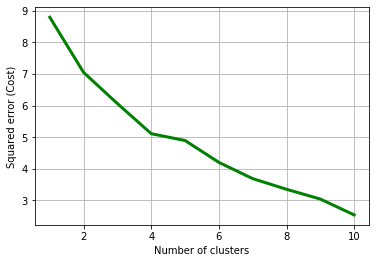

In [309]:
plt.plot(range(1,11),cost,color='g',linewidth='3')
plt.xlabel("Number of clusters")
plt.ylabel("Squared error (Cost)")
plt.grid()
plt.show()

The plot demonstrates that while choice of 2 or three clusters is clearly suboptimal, with each additional cluster there is only moderate reduction of squared error. We therefore will choose 4 clusters to coninue with.

In [310]:
kclusters = 4

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(mass_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

In [311]:
mass=pd.merge(mass,zip_venues_sorted)

In [312]:
mass['Cluster Labels'] = kmeans.labels_

### Visualization of criminal data

The following code will summarize average property and violence crime rates for each municipal cluster. Barplots will visualize this data and enable to easily compare crime rates across clusters

In [313]:
mass['VR'] = (mass['Violent rate'].astype(float))*1000
mass['PR'] = (mass['Property rate'].astype(float))*1000

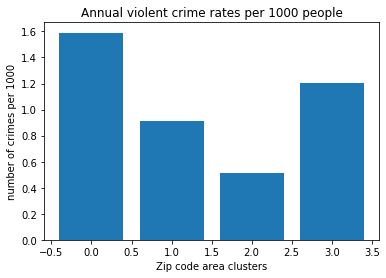

In [314]:
import matplotlib.pyplot as plt
VR = mass.groupby('Cluster Labels').agg({'VR': ['mean']})
VR = pd.DataFrame(VR)
VR['Cluster']=VR.index
VR.columns = ['Rate', 'Cluster']
plt.title('Annual violent crime rates per 1000 people')
plt.xlabel('Zip code area clusters')
plt.ylabel('number of crimes per 1000')
plt.bar(VR['Cluster'],VR['Rate'])
plt.show()

Property crime rates were different between the municipalities

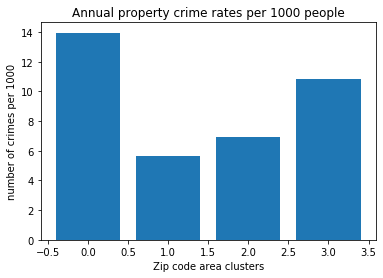

In [315]:
PR = mass.groupby('Cluster Labels').agg({'PR': ['mean']})
PR = pd.DataFrame(PR)
PR['Cluster']=PR.index
PR.columns = ['Rate', 'Cluster']
plt.bar(PR['Cluster'],PR['Rate'])
plt.title('Annual property crime rates per 1000 people')
plt.xlabel('Zip code area clusters')
plt.ylabel('number of crimes per 1000')
plt.show()

### Mapping clusters

In [316]:
map_clusters = folium.Map(location=[latW, lonW], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(mass['Latitude'], mass['Longitude'], mass['City'], mass['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
map_clusters

Municipalities from clusters 1 and 2 had lowest crime rates. We will inspect the venues to finalize the decision on relocation.

In [324]:
mass.loc[mass['Cluster Labels'] == 1, mass.columns[[1] + list(range(5, mass.shape[1]))]]

,City,Timezone,Daylight savings time flag,Distance,Range,Color,Violent rate,Property rate,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Cluster Labels,VR,PR
21,Lincoln,-5,1,4.671661,Yes,green,0.000914216,0.00563767,Museum,Yoga Studio,French Restaurant,Food Truck,Food & Drink Shop,Food,Flower Shop,Flea Market,Fish Market,Field,1,0.914216,5.637666


In [318]:
mass.loc[mass['Cluster Labels'] == 2, mass.columns[[1] + list(range(5, mass.shape[1]))]]

,City,Timezone,Daylight savings time flag,Distance,Range,Color,Violent rate,Property rate,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Cluster Labels,VR,PR
24,Wellesley,-5,1,11.0962,Yes,green,0.000516298,0.00695281,Construction & Landscaping,Yoga Studio,Ethiopian Restaurant,Food Truck,Food & Drink Shop,Food,Flower Shop,Flea Market,Fish Market,Field,2,0.516298,6.95281


## Results

Following clustering, two municipalities remained to choose from. After inspection of the map and the venue summary, we have decided on Wellesley. 

## Discussion

In this project, I have applied the skills of management of geospatial data, data manipulation and clustering in order to choose the optimal place for living. The resulting number of places to choose from was small, making the choice easier. This was probably possible due to clear setting of priorities, which may vary from person to person. Some may choose a place which is predominantly populated by people of their ethnic community. Others may wish to live very close to their workplace in order to get there on foot and avoid buying a car. Some people may need a more detailed elimination protocol that would include rent rates and proximity to public transport.
The results were surprizing and did not resemble the conventional search that I have performed previously, by asking people about Boston area neighborhoods. I was then recommended a few rich neighborhoods. It is possible that people do not take into account safety data when making a decision on relocation. On the other hand, this data elimination protocol may err due to incomplete or outdated crime data (2013). Additionally, it is possible that despite some differences in crime rates between the postal code zones, the overall crime rates are relatively low, so that people feel equally safe in all zones.

## Coclusions

Application of Data Science skills enabled to choose by elimination an optimal place to live. It can be advantageous if we choose to rely on the algorithm in our choice. However, there is a danger in coming to a small number of options if we suspect that some basic assumptions are wrong. In this case it may be better to have a larger output  and continue manual search.